In [440]:
using Revise

In [441]:
@everywhere using Pkg
@everywhere Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

      From worker 4:	  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`
      From worker 7:	  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`
      From worker 5:	  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`
      From worker 6:	  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`
      From worker 8:	  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`


  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`


In [442]:
@everywhere using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM,DelimitedFiles

In [443]:
@everywhere using SuSiEGLMM

In [547]:
pwd()

"/Users/jeankim/GIT/susie-glmm/SuSiEGLMM.jl/test"

In [200]:
?glmmSusie

search: glmmSusie



```
 glmmSusie(y::Vector{Float64},X::Matrix{Float64},X₀::Union{Matrix{Float64},Vector{Float64}},T::Matrix{Float64},
      S::Vector{Float64};tol=1e-4,τ²::Float64 = 1.99,L::Int64=10,Π::Vector{Float64}=ones(size(X,2))/size(X,2),σ0::Vector{Float64} = ones(L))


 Fit a logistic mixed model for SUSIE (sum of single effects).  Returns a type of `Result`, struct of arrays.
```


In [106]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

#empirical grm
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

  1.095364 seconds (18.08 M allocations: 513.283 MiB, 6.31% gc time, 10.40% compilation time)


In [107]:
Seed(24)

In [108]:
T,S = svdK(K0;LOCO=false) 

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787193 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479863 … 0.001685475850207202 -0.02001944231048721; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

In [220]:
size(X)

(503, 4000)

In [110]:
X1= (X.-mean(X,dims=1))./std(X,dims=1)
n,p = size(X1)

L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 


In [11]:
# data preparation
    τ2= 1.5  # true τ²

#for j = 1:B
    b_true[1]= randn(1)[1] 

    g=rand(MvNormal(τ2*K0)) #grm
    p= logistic.(X1*b_true+g) 
    #generating binary outcome
    Y=convert(Vector{Float64} ,rand.(Bernoulli.(p))) ;  
    X₀=ones(n,1); #covariates(intercepts)

In [12]:
b_true[1] # true b

0.12169754246032718

In [38]:
 # transforming data         
     Xt, Xt₀, y1 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
#      y1= SuSiEGLMM.rotateY(Y1,T)

#initial values
#     τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

([0.6203341866904861 1.2821380992099884 … 1.043867526136292 -0.1389906140735533; -0.6509038299601514 -1.2818875721823844 … -1.4765123447412196 0.9787359714523717; … ; 0.3973684522059859 -0.6252119514266032 … 0.2937676417753836 -0.4056734188047211; 2.498001805406602e-16 -1.3877787807814457e-15 … -1.3877787807814457e-15 -3.7192471324942744e-15], [8.104628079763643e-15; -1.7763568394002505e-15; … ; 5.176414852314792e-15; -22.427661492005853;;], [0.7380182007198995, 0.4932809620366664, -0.20932647335519852, 0.23574420649902875, -0.3390369393086783, -0.3800707480870755, 0.4493067890313288, -0.07527503784950619, 1.0065495959264241, 0.34437937462374313  …  -0.5050540161006902, 0.04812784483224336, 0.6473613710563536, -0.19269570999865615, -0.06470431183997619, 0.7611326098578076, -0.03169940760200806, -0.14082160584554093, -0.07353240261188163, 0.6911108412049504])

In [13]:
#debugging
@time res= glmmSusie(Y,X1,X₀,T,S;tol=tol,τ²= 2.5,L=L)


603
 27.252065 seconds (15.07 M allocations: 34.603 GiB, 11.85% gc time, 16.14% compilation time)


Result([0.6524901182755911, 0.6184070968466127, 0.5943665763273984, 0.59448456203368, 0.5994032482415731, 0.6004846477838822, 0.6042359291378836, 0.5823473445565246, 0.6744000444794052, 0.5916156772494535  …  0.30955338895943496, 0.3053677182659665, 0.309713935703812, 0.3031921977927418, 0.3022731558892352, 0.3085713469350707, 0.29870644878756264, 0.2978323051344029, 0.2943472226636677, 387.11614412912763], [-17.22842782143601], [0.00011555910625579783], 0.21061676102332783, -659.5636349583392, [0.00026010953356224697; 0.00025035081029284485; … ; 0.00024955448027751093; 0.0002528484160712172;;], [0.0032477313605729103; -0.001350480971123967; … ; -0.0010475188478008975; 0.0020219294738140635;;], [0.00011404312077513636; 0.00011404517578826095; … ; 0.00011404499816229501; 0.00011404502041071244;;])

In [31]:
logistic(minimum(res.ξ))

0.5730600703457543

In [219]:
X₀

503×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [242]:
τ²=1.99; Π=ones(p)/p;σ0=ones(L);
Σ0= 2(cov(Xt₀)+I) # initial variance of prior β
ξ0=guessξ0(y1,Xt₀,Xt,S,Σ0,τ²,σ0,Π,n,L)

Xy₀=SuSiEGLMM.getXy('T',Xt₀,y1)
Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 

intOut([0.4307742070354993;;], [-35.981727194550245], [0.7380182007199507, 0.4932809620366551, -0.20932647335519286, 0.23574420649905492, -0.3390369393086967, -0.38007074808708086, 0.44930678903129045, -0.07527503784950708, 1.0065495959263921, 0.34437937462373386  …  -0.5050540161006711, 0.04812784483220738, 0.6473613710564481, -0.19269570999859847, -0.06470431183994825, 0.7611326098578247, -0.031699407602064515, -0.14082160584559789, -0.0735324026118394, 0.401086479829557], [0.17561276958721417, 0.17624690280351132, 0.17686404107337775, 0.17705289578756672, 0.1772204811097033, 0.1775268778410138, 0.17783076804123119, 0.1782866724091776, 0.1783054751785328, 0.1785844113702009  …  0.22506367991207377, 0.2251500584550706, 0.225363119768363, 0.22553800695881884, 0.22561818879569284, 0.22581374737654525, 0.22611998026381633, 0.2262800597987398, 0.22675300657374733, 0.0003593920617007933], [1.4232761835615985e-15 -3.1307739121812847e-16 … 1.1737676310353795e-15 -0.008060323502739473], [2.67

In [277]:
#  ghat =zeros(n); Vg = zeros(n);
#     ghat2=zeros(n); τ2_new=zeros(1); τ2 =[τ²]; 
    
#     βhat=zeros(c)
#     A0 =repeat(Π,outer=(1,L)) ; 
#     B0=zeros(p,L); AB2=zeros(p,L)
   
#     A1 =copy(A0); B1=zeros(p,L); Sig1=zeros(p,L)
#     σ0_new = zeros(L); ξ_new = zeros(n);

#  el0=0.0;
# Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 
# postG!(ghat,Vg,Badj,Xt,S,τ2,A0,B0)
# emG!(ghat2,τ2_new,Vg,ghat,S)

postB!(A1, B1, Sig1,Badj,ghat,Xt,σ0,A0,B0,Π,L)
σ0_new, AB2 = emB(A1, B1, Sig1,L)
mStep!(ξ_new,A1,B1,Sig1,ghat,Vg,Badj,Xt,Xt₀,n)
el1=ELBO(ξ_new,σ0_new,τ2_new,Badj,A1,B1,AB2,Sig1,Π,ghat,ghat2,Vg,S,Xt,Xy₀,Σ0,L,n)

# crit=abs(el1-el0)
# ξ0[:]=ξ_new; τ2[:]=τ2_new;el0=el1;σ0[:]=σ0_new;βhat[:]=Badj.β̂;
#          A0[:,:]=A1;B0[:,:]=B1
        

-688.3037305907769

In [278]:
[σ0 σ0_new]

1×2 Matrix{Float64}:
 0.0116125  0.00773446

In [279]:
[ξ0 ξ_new]

503×2 Matrix{Float64}:
   2.18471     2.13398
   1.77679     1.73949
   1.48504     1.4605
   1.50019     1.47505
   1.58349     1.55437
   1.62096     1.59003
   1.69475     1.66074
   1.41481     1.39306
   2.64347     2.58615
   1.57112     1.54229
   1.86755     1.82661
   3.28979     3.23635
   1.48032     1.45544
   ⋮         
   0.874822    0.85898
   1.03308     1.00929
   0.932049    0.91323
   0.854354    0.839341
   0.972162    0.951067
   0.858492    0.843031
   0.847381    0.832447
   1.00356     0.980685
   0.837853    0.823091
   0.840699    0.825659
   0.828403    0.8137
 619.969     530.915

In [275]:
# gs=zeros(n,4)
gs[:,:]=[ghat ghat2 S Vg]
gs

503×4 Matrix{Float64}:
  1.55317       4.52246      1.84986      2.11013
  0.993047      3.00602      1.82617      2.01988
 -0.408181      2.12222      1.80236      1.95561
  0.4586        2.16388      1.79537      1.95357
 -0.663658      2.40312      1.78867      1.96268
 -0.743439      2.51402      1.77723      1.96131
  0.881018      2.74219      1.76599      1.96599
 -0.143756      1.93135      1.749        1.91068
  2.12691       6.64125      1.7485       2.11752
  0.662307      2.36622      1.73815      1.92757
 -1.16037       3.31738      1.73116      1.97091
 -2.86231      10.3999       1.72723      2.2071
 -0.454689      2.10769      1.71896      1.90095
  ⋮                                       
 -0.156691      0.735142     0.459797     0.71059
 -0.551709      1.01347      0.456579     0.709088
 -0.355644      0.83099      0.454373     0.704508
  0.0336485     0.702103     0.452587     0.700971
  0.450798      0.900373     0.448211     0.697155
 -0.133036      0.708328     0.

In [258]:
[ghat ghat2 S Vg]

503×4 Matrix{Float64}:
  1.59677       4.72592     1.84986      2.17624
  1.02103       3.12787     1.82617      2.08537
 -0.418988      2.19075     1.80236      2.0152
  0.469304      2.23398     1.79537      2.01374
 -0.682421      2.48971     1.78867      2.02401
 -0.764698      2.60784     1.77723      2.02308
  0.906089      2.84969     1.76599      2.02869
 -0.148333      1.98951     1.749        1.9675
  2.17879       6.91998     1.7485       2.17283
  0.681169      2.45153     1.73815      1.98754
 -1.19469       3.46088     1.73116      2.03359
 -2.91015      10.7162      1.72723      2.24721
 -0.467309      2.17716     1.71896      1.95878
  ⋮                                      
 -0.161591      0.761613    0.459797     0.735501
 -0.570481      1.05968     0.456579     0.734231
 -0.368159      0.864858    0.454373     0.729317
  0.034719      0.726774    0.452587     0.725568
  0.46611       0.93911     0.448211     0.721851
 -0.137922      0.733956    0.444564     0.714934


In [232]:
 #posterior
#         Vg[:]= 1.0./(Badj.λ+1.0./(τ2[1]*S))
        
#         ghat[:]= SuSiEGLMM.getXy('N',Xt,sum(A0.*B0,dims=2)[:,1])
#         ghat[:]= Badj.Ŷ -lmul!(Diagonal(Badj.λ),ghat)
#         lmul!(Diagonal(Vg),ghat)
#          ghat2[:]= Vg+ghat.^2 
    #m-step for τ²
    τ2_new[:].= mean(ghat2./S)

1-element view(::Vector{Float64}, :) with eltype Float64:
 1.787907725248363

In [276]:
[τ2 τ2_new]

1×2 Matrix{Float64}:
 1.85555  1.78609

## Testing score test 

In [111]:
#fix true values of parameters
τ2=0.5;b_true[1]=randn(1)[1]
println(b_true[1])#true b
# init0=[]; init1=[]
B=200

#  tt=zeros(B);
#Ps=zeros(p,R); 
#  Ts1=zeros(p,B);#Ps1=zeros(p,R);
Y0=zeros(n,B);
Y1=zeros(n,B);


for j = 1:B
#     b_true[1]= randn(1)[1] # true b 
#     b_1s[j] = b_true[1]   
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    p0= logistic.(g)
    p1=logistic.(X1*b_true+g) 
    
    Y0[:,j]=rand.(Bernoulli.(p0)) #H0 data
    Y1[:,j]=rand.(Bernoulli.(p1)) #H1 data
    # similarily :
#     Y[:,j] = collect(Iterators.flatten(rand.(Bernoulli.(p1), 1))) 
    # Y0[:,j]=Y1
end

0.12169754246032718


In [548]:
# writedlm("./Seed24_simY0glmm.txt",Y0)
# writedlm("./Seed24_simY1glmm.txt",Y1)

In [546]:
sum(Y0[:,158])

270.0

In [543]:
[init0[end].β init1[end].β]

1×2 Matrix{Float64}:
 25.1955  -73.1551

In [539]:
Mx=[maximum([init0[j].ξ init1[j].ξ];dims=1) for j=1:B] # check max ξ for each replicate

200-element Vector{Matrix{Float64}}:
 [3.4284292342498155 2.819471699704196]
 [13.489377765911394 2.640503408030776]
 [2.819471699704192 4.8850836892275025]
 [209.8960528571761 4.885083689227508]
 [6.88398586002103 565.7155903023825]
 [47.20419301714131 2.4376274432093163]
 [2.8194716997041915 6.883985860021055]
 [298.1825142576825 2.399343709750721]
 [209.89605285717812 2.8194716997041933]
 [123.55477143133304 2.4376274432093132]
 [565.7155903023806 2.437627443209316]
 [2.8194716997041933 4.88508368922753]
 [3.4284292342498257 4.885083689227525]
 ⋮
 [2.437627443209314 2.819471699704192]
 [2.4376274432093146 2.8194716997041933]
 [834.2744758270882 2.8194716997041858]
 [3.4284292342498213 2.3993437097507213]
 [4.88508368922751 565.7155903023821]
 [3.070726738372716 6.883985860020989]
 [3.4284292342498155 2.8194716997041955]
 [2.6405034080307814 1282.406069599408]
 [387.1161441291258 2.516357105094869]
 [3.0707267383727146 209.8960528571761]
 [2.437627443209316 2.516357105094871]
 [565.7

In [540]:
Mx[158]

1×2 Matrix{Float64}:
 655.183  2.6405

In [130]:
Inx=findall(Pv0.<0.05);
Pv0[Inx]
Inx[31] #pick one that is extremely small

158

In [117]:
minimum([V0 V1],dims=1) #minimum variances in  H0, H1 data

1×2 Matrix{Any}:
 24.8793  18.7425

In [134]:
logistic.(maximum([init0[158].ξ init1[158].ξ];dims=1))

1×2 Matrix{Float64}:
 1.0  0.933423

In [119]:
display([Pv0[158] P1[158];S0[158] S1[158];V0[158] V1[158]])

3×2 Matrix{Float64}:
  5.97398e-5   0.00203614
 23.6193      22.2284
 34.6268      51.9195

In [541]:
b_true[1]

0.12169754246032718

In [150]:
# ŷ 
r₀=similar(Y0); r₁=similar(Y1);ŷ0=zeros(n,B);ŷ1=zeros(n,B);ŷ2=zeros(n,B);ŷ3=zeros(n,B);
for j=1:B
   r₀[:,j] =  (2Y0[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init0[j].β)+SuSiEGLMM.getXy('T',T,init0[j].μ)) 
   r₁[:,j] =  (2Y1[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init1[j].β)+SuSiEGLMM.getXy('T',T,init1[j].μ)) 
   ŷ0[:,j] = logistic.(init0[j].ξ).*exp.(0.5*(r₀[:,j]-init0[j].ξ))
   ŷ1[:,j] = logistic.(init1[j].ξ).*exp.(0.5*(r₁[:,j]-init1[j].ξ))   
    # full lower bound
   ŷ2[:,j] = log.(logistic.(init0[j].ξ))+0.5*(r₀[:,j]-init0[j].ξ)-Lambda.(init0[j].ξ).*(r₀[:,j].^2-init0[j].ξ.^2)
   ŷ2[:,j] =  exp.(ŷ2[:,j])
   ŷ3[:,j] =  log.(logistic.(init1[j].ξ))+0.5*(r₁[:,j]-init1[j].ξ)-Lambda.(init1[j].ξ).*(r₁[:,j].^2-init1[j].ξ.^2)
    ŷ3[:,j] = exp.(ŷ3[:,j])   
end

In [191]:
y0=similar(Y0);
for j=1:B
y0[:,j] = logistic.( SuSiEGLMM.getXy('N',X₀,init0[j].β)+SuSiEGLMM.getXy('T',T,init0[j].μ))
    
end
    
    

In [221]:
[init0[1].τ2 init0[1].β; init1[1].τ2 init1[1].β]

2×2 Matrix{Float64}:
 0.30702    -0.0942061
 0.0759736  -0.0566676

### check with fitting H1 model for an erratic Y0, Y1

In [391]:
@time b0,est0=scan1SNP(Y0[:,1],X1[:,[1]],X₀,T,S;tol=tol,τ0=τ2, σ_0= 1.0); #H0 data
@time b1,est1=scan1SNP(Y1[:,1],X1[:,[1]],X₀,T,S;tol=tol,τ0=τ2, σ_0= 1.0); #H1 data

322
  5.959619 seconds (26.20 k allocations: 6.729 GiB, 11.93% gc time)
1051
 19.168492 seconds (85.25 k allocations: 21.960 GiB, 12.06% gc time)


In [392]:
[est0[1].τ2 est0[1].β b0  est0[1].σ1 est0[1].elbo ; est1[1].τ2 est1[1].β b1 est1[1].σ1 est1[1].elbo]

2×5 Matrix{Any}:
 0.304962   -0.0942061  0.0110372   0.000937248  -602.874
 0.0758768  -0.0566676  1.05712e-5  7.79549e-6   -603.311

### tracking parameters and elbo by fitting H0 model

In [400]:
 
# n=length(Y0[:,end])
# # check if covariates are added as input and include the intercept. 
#     if(X₀!= ones(n,1)) #&&(size(X₀,2)>1)
#         X₀ = hcat(ones(n),X₀)
#     end
# Xt₀= rotateX(X₀,T)
yt = rotateY(Y1[:,2],T);

In [397]:
# τ0=[2.0]
τ0=[τ2]
Σ0= 2(cov(Xt₀)+I) # avoid sigularity when only with intercept   
display(Σ0)
# ξ0=guessξ0(yt,Xt₀,S,Σ0,τ0,n)
sig0=getXX('N',Σ0,'T',Xt₀)
#   β̂0=getXy('N',sig0,yt)
 β̂0=[0.0]

1×1 Matrix{Float64}:
 4.000000000000009

1-element Vector{Float64}:
 0.0

In [398]:
  ξ0 =sqrt.(getXy('N',Xt₀,β̂0 ).^2+ Diagonal(getXX('N',Xt₀,'N',sig0))*ones(n)+τ0[1]*S);

In [401]:
[τ0 β̂0]
#  ξ0

1×2 Matrix{Float64}:
 0.5  0.0

In [402]:
#emNull
n,c=size(Xt₀)
    ghat =zeros(n); Vg = zeros(n);
    ghat2=zeros(n); τ2_new=zeros(1); #τ0 =[τ0]; 
    ξ_new = zeros(n); βhat=zeros(c)
    
    Xy₀=getXy('T',Xt₀,yt) #X₀'y
   
   
    crit =1.0; el0=-1000.0;numitr=0
#     open(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl/test/dbtracking_trueval_upAll.txt","w") 
     open("./decELBO.txt","w")
    while (crit>=tol)
        ###check again!
         Badj= intβOut(Xy₀,yt,Xt₀,Σ0,ξ0,n) 
#          Badj.β̂=β̂0
         postG!(ghat,Vg,Badj,S,τ0)
         emG!(ghat2,τ2_new,Vg,ghat,S)
#          τ2_new[:] = τ0
         mStep!(ξ_new,Vg,ghat,Badj,Xt₀,n)

         el1=ELBO(ξ_new,τ2_new,Badj,ghat,ghat2,Vg,S,Xy₀,Σ0,n)
    
    if(el0>el1)
          f=open("./decELBO.txt","a")
            writedlm(f,[numitr Badj.β̂ τ2_new el1 el1-el0])
          close(f)
         end
         
         crit=abs(el1-el0)
        #  crit=norm(ξ_new-ξ)+norm(τ2_new-τ2)+abs(el1-el0)  
        
         ξ0[:]=ξ_new; τ0[:]=τ2_new;el0=el1;βhat[:]=Badj.β̂
    
#         f1=open("./dbtracking_trueval_upAll.txt","a")
#            writedlm(f1,[βhat τ2_new el1])
#         close(f1)
    
          numitr +=1        
    end
    println(numitr)
#     return Approx0(βhat,ξ,ghat,τ2[1],el0)
    





387


In [403]:
[βhat τ2_new el0]

1×3 Matrix{Float64}:
 -0.0422631  0.264551  -602.967

In [404]:
ξ_new

503-element Vector{Float64}:
 0.6727361390489073
 0.6698379303824752
 0.7235079371261476
 0.659948242667934
 0.7060242357451123
 0.7911102910214589
 0.7088216276630139
 0.7695823202816024
 0.7772646175783305
 0.6687606020466254
 0.6482250935556133
 0.7085884747238769
 0.6414139645753524
 ⋮
 0.3463424005885976
 0.34696941153234573
 0.343532106276104
 0.34115083354561543
 0.3473894719685031
 0.34849726813196513
 0.3395023906116097
 0.3360925712364236
 0.3436565278257265
 0.33248927240393844
 0.3435886472733089
 2.640503408030776

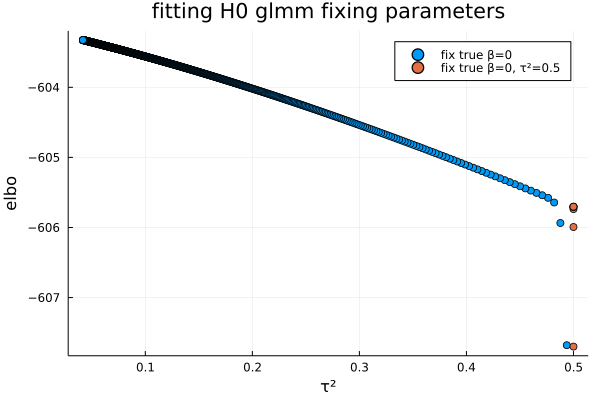

In [507]:
data=readdlm("./dbtracking_fixbeta.txt")
dtrue=readdlm("./dbtracking_truefix.txt")
scatter(data[:,2],data[:,end],xlab="τ²",ylab="elbo", label="fix true β=0",title="fitting H0 glmm fixing parameters")
scatter!(dtrue[:,2],dtrue[:,end],label="fix true β=0, τ²=0.5")

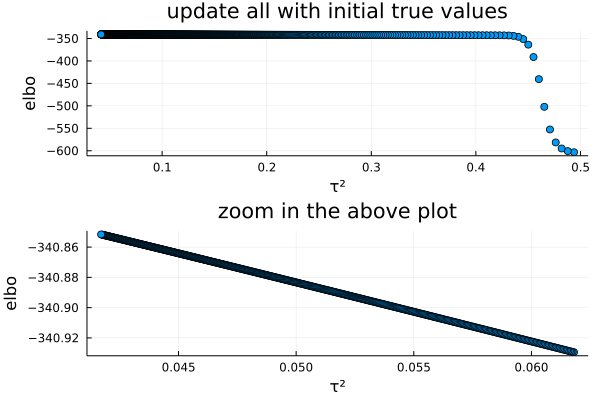

In [346]:
data1=readdlm("./dbtracking_trueval_upAll.txt")
p0=scatter(data1[:,2],data1[:,end],xlab="τ²",ylab="elbo",label="", title="update all with initial true values")
p1=scatter(data1[800:end,2],data1[800:end,end],xlab="τ²",ylab="elbo",label="", title="zoom in the above plot")
plot(p0,p1,layout=@layout[a;b])

In [410]:
#  sig0=getXX('N',Σ0,'T',Xt₀)
#   β̂0=getXy('N',sig0,yt)
τ1=[τ2]
# τ1=[2.0]
σ0=[1.0]
  ξ1 =sqrt.(getXy('N',Xt₀,β̂0 ).^2+ Diagonal(getXX('N',Xt₀,'N',sig0))*ones(n)+σ0[1]*Xt[:,1].^2+τ1[1]*S)


503-element Vector{Float64}:
  1.1444414734044657
  1.156184527495826
  1.3504065082668517
  0.9809994726613387
  0.9552916983470006
  2.1982153985302055
  1.2449341694751548
  1.0788231554286674
  1.5555897104867178
  1.972985483799921
  0.9807041858524187
  0.9416929793115546
  1.0259184371152759
  ⋮
  0.670845106106226
  1.2690183375901913
  1.3600391746083438
  0.5281736226005375
  0.801031394801333
  0.7215750384337595
  0.7352722780226242
  0.7599806749223457
  0.5631699724364218
  1.694091937060221
  0.6064264759319588
 44.85532298401176

In [411]:
  #emAlt: H1: 1 QTL
    ghat =zeros(n); Vg = zeros(n);
    
    ghat2=zeros(n); τ1_new=zeros(1); #τ2 =[τ2]; 
    b0=zeros(1); b1=zeros(1);b2=zeros(1); σ1=zeros(1)
    σ0_new =zeros(1); #σ0=[σ0]
    ξ1_new = zeros(n); βhat1=zeros(c)
    
#     Xy₀=getXy('T',Xt₀,yt) #X₀'y
    # Vβ̂inv,Badj = covarAdj(Xy₀,yt,Xt₀,Σ₀,ξ,n)
   
    crit =1.0; elb0=-1000.0;numitr=0
    # open(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl/test/est_elbo1.txt","w") 
     open("./decELBO1.txt","w")
    while (crit>=tol)
        ###check again!
         Badj= intβOut(Xy₀,yt,Xt₀,Σ0,ξ1,n) 
#           Badj.β̂=β̂0
         postG!(ghat,Vg,Badj,S,τ1,Xt[:,1],b0)
         emG!(ghat2,τ1_new,Vg,ghat,S)
         postB!(b1,σ1,Badj,ghat,Xt[:,1],σ0)
         emB!(b2,σ0_new,b1,σ1)
         mStep!(ξ1_new,b1,σ1,Vg,ghat,Badj,Xt₀,Xt[:,1],n)

         elb1=ELBO(ξ1_new,τ1_new,σ0_new,Badj,b1,b2,σ1,ghat,ghat2,Vg,S,Xt[:,1],Xy₀,Σ0,n)
     
         if(elb0>elb1)
          f=open("./decELBO1.txt","a")
            writedlm(f,[numitr Badj.β̂ τ1_new  b1 σ1 elb1 elb1-elb0])
          close(f)
         end
         crit=abs(elb1-elb0)
        #  crit=norm(ξ_new-ξ)+norm(τ2_new-τ2)+abs(el1-el0)  
        
         ξ1[:]=ξ1_new; τ1[:]=τ1_new;elb0=elb1;σ0[:]=σ0_new;βhat1[:]=Badj.β̂
         b0[:]=b1
        
          numitr +=1        
    end
    println(numitr)

421


In [412]:
[βhat1 τ1_new elb0 b1 b2]
# β̂0

1×5 Matrix{Float64}:
 -0.0422631  0.248265  -602.458  0.114536  0.01882

In [413]:
ξ1_new

503-element Vector{Float64}:
 0.6690152521772111
 0.6676799055165796
 0.7500825588986708
 0.6380120072148185
 0.6781513097671645
 0.9065935879132019
 0.6595902372490203
 0.7739072372999656
 0.8319277438979688
 0.6389710154062844
 0.6265495366222787
 0.6786655041329945
 0.6230465474449733
 ⋮
 0.3353950295850507
 0.3528151261926381
 0.38674979535068904
 0.3318281567505135
 0.3327836258233029
 0.33095901115094273
 0.3439020007693346
 0.33656773206792523
 0.3271176103882134
 0.38925999939372463
 0.3486949520020439
 2.640503408030775

In [424]:
y1

503×200 Matrix{Float64}:
 0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  …  0.0  1.0  1.0  0.0  1.0  1.0  1.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0     0.0  1.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0     1.0  0.0  1.0  1.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  …  1.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0     0.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0     0.0  1.0  1.0  0.0  1.0  0.0  1.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0     1.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0

### QTL scan: checking estimates vs true SNP effects(b)

In [444]:
Seed(200)

In [445]:
#fix true values of parameters
D=200
τ2_true=0.8;b_1=zeros(p)
b_1s=zeros(D)

y0=zeros(n,D);
y1=zeros(n,D);


for j = 1:D
    b_1[1]= randn(1)[1] # true b 
    b_1s[j] = b_1[1]   
   
# data generation
    g=rand(MvNormal(τ2_true*K0)) #grm
    
    p0= logistic.(g)
    p1=logistic.(X1*b_1+g) 
    
    y0[:,j]=rand.(Bernoulli.(p0)) #H0 data
    y1[:,j]=rand.(Bernoulli.(p1)) #H1 data
  
end

In [446]:
# addprocs(5)
nprocs()

6

In [ ]:
Bs=zeros(10,D);
Bs[:,1], par0= scan1SNP(y1[:,1],X1[:,1:10],X₀,T,S)
for j=2:D
  Bs[:,j],par = scan1SNP(y1[:,j],X1[:,1:10],X₀,T,S)
  par0=[par0 par]
end
    

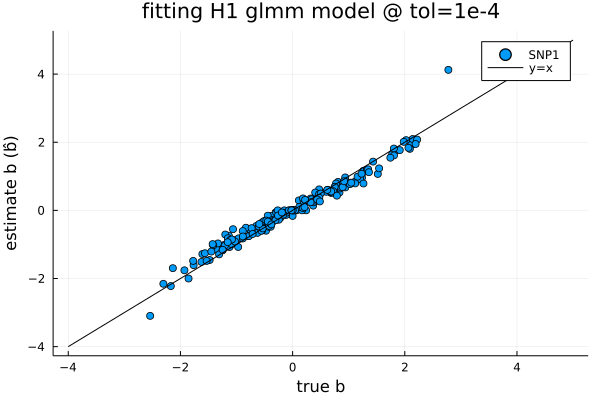

In [499]:
# writedlm("./fullglmm_sim_trueb_estb.txt",[b_1s';Bs])
x=collect(-4:5)
scatter(b_1s,Bs[1,:],xlab="true b",ylab="estimate b (b̂)",label="SNP1",title="fitting H1 glmm model @ tol=1e-4" )
plot!(x,x,linecolor=:black, label="y=x")

In [464]:
display([minimum(b_1s) maximum(b_1s);minimum(Bs[1,:]) maximum(Bs[1,:])]) #[true b;estimates]

2×2 Matrix{Float64}:
 -2.53962  2.77715
 -3.09756  4.12548

#### Violin plots for SNPs near (signaled) SNP1 without effects (b=0)

In [474]:
using StatsPlots

In [491]:
minimum(Bs[2:end,:])

-0.30838873919207865

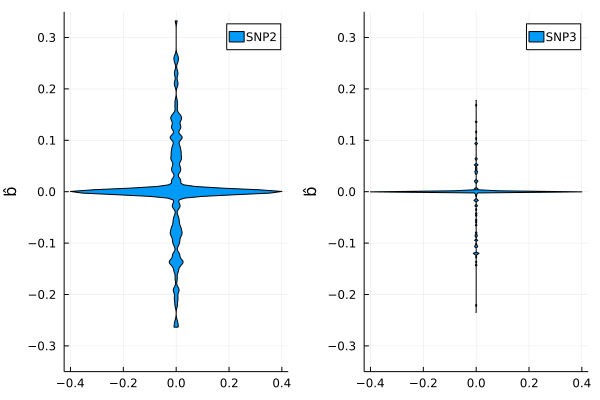

In [493]:
# violin(zeros(D),Bs[2,:],label="")
s1=violin(zeros(D),Bs[2,:],label="SNP2",ylim=(-0.35,0.35),ylab="b̂")
s2=violin(zeros(D),Bs[3,:],label="SNP3",ylim=(-0.35,0.35),ylab="b̂")
plot(s1,s2,layout=@layout[a b])

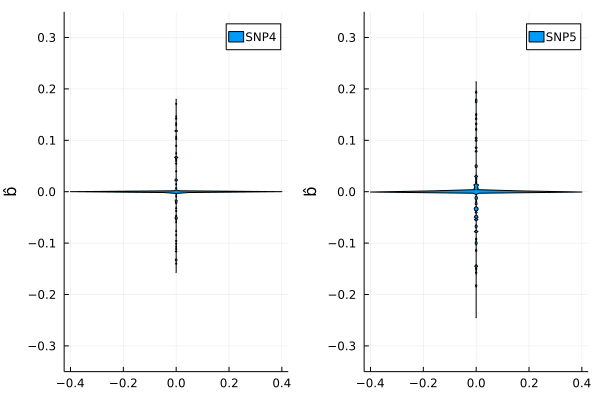

In [494]:
s3=violin(zeros(D),Bs[4,:],label="SNP4",ylim=(-0.35,0.35),ylab="b̂")
s4=violin(zeros(D),Bs[5,:],label="SNP5",ylim=(-0.35,0.35),ylab="b̂")

plot(s3,s4,layout=@layout[a b])

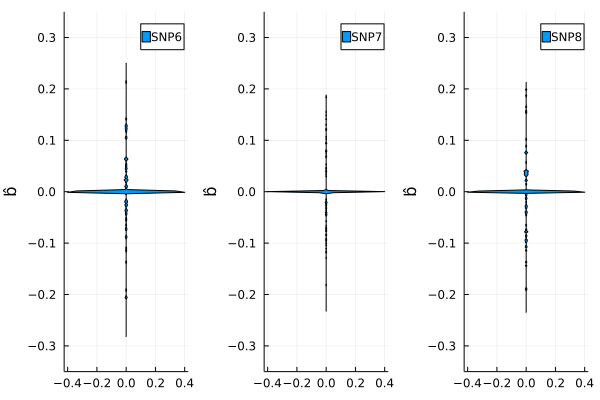

In [497]:
s5=violin(zeros(D),Bs[6,:],label="SNP6",ylim=(-0.35,0.35),ylab="b̂")
s6=violin(zeros(D),Bs[7,:],label="SNP7",ylim=(-0.35,0.35),ylab="b̂")
s7=violin(zeros(D),Bs[8,:],label="SNP8",ylim=(-0.35,0.35),ylab="b̂")
plot(s5,s6,s7,layout=@layout[a b c])

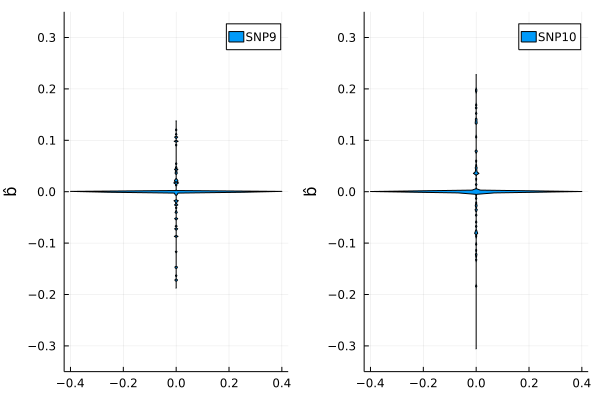

In [506]:
s8=violin(zeros(D),Bs[9,:],label="SNP9",ylim=(-0.35,0.35),ylab="b̂")
s9=violin(zeros(D),Bs[end,:],label="SNP10",ylim=(-0.35,0.35),ylab="b̂")
plot(s8,s9,layout=@layout[a b ])

### quick check for H1 model fitted by H0 data: SNP1 only

In [ ]:
#fitting H0 data
B0=[];h0par=[]

for j=1:D
  b̂,par = scan1SNP(y0[:,j],X1[:,[1]],X₀,T,S)
  B0=[B0;b̂]
  h0par=[h0par ;par]
end


    

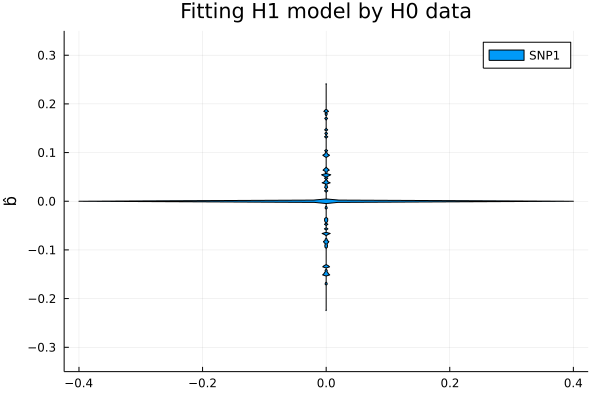

In [524]:
# writedlm("./fullglmm_sim_estb4H0data.txt",B0)
violin(zeros(D),B0,label="SNP1",ylim=(-0.35,0.35),ylab="b̂",title="Fitting H1 model by H0 data")


### examine replicates producing incorrect fixed effects

In [564]:
#obtaining  β̂ off from 0 
β̂s0=[init0[j].β for j=1:B]; #from H0 data
β̂s1=[init1[j].β for j=1:B]; # from H1 data
[β̂s0 β̂s1]

200×2 Matrix{Vector{Float64}}:
 [-0.0942061]  [-0.0566676]
 [0.555725]    [-0.0422631]
 [0.0566676]   [-0.166795]
 [9.32184]     [0.166795]
 [-0.25879]    [-25.1955]
 [2.0617]      [-0.0172723]
 [-0.0566676]  [-0.25879]
 [13.2609]     [-0.00570623]
 [-9.32184]    [-0.0566676]
 [5.46918]     [-0.0172723]
 [25.1955]     [0.0172723]
 [-0.0566676]  [-0.166795]
 [0.0942061]   [-0.166795]
 ⋮             
 [-0.0172723]  [-0.0566676]
 [0.0172723]   [-0.0566676]
 [37.1741]     [0.0566676]
 [0.0942061]   [-0.00570623]
 [0.166795]    [-25.1955]
 [0.0734403]   [0.25879]
 [-0.0942061]  [0.0566676]
 [0.0422631]   [57.1601]
 [-17.2284]    [0.029322]
 [0.0734403]   [-9.32184]
 [0.0172723]   [0.029322]
 [25.1955]     [-73.1551]

In [572]:
[β̂s0[2] β̂s1[2]]

1×2 Matrix{Float64}:
 0.555725  -0.0422631

In [575]:
[init0[2].ξ init1[2].ξ]
# logistic.([init0[2].ξ init1[2].ξ])

503×2 Matrix{Float64}:
  0.382589  0.672808
  0.377428  0.66991
  0.375368  0.723597
  0.373758  0.660018
  0.38363   0.706108
  0.376214  0.791219
  0.376437  0.708907
  0.370164  0.769686
  0.369039  0.777371
  0.368546  0.668835
  0.367234  0.648294
  0.372762  0.708676
  0.36662   0.641481
  ⋮         
  0.191776  0.346382
  0.191737  0.347009
  0.190977  0.343571
  0.190207  0.341189
  0.189496  0.34743
  0.188804  0.348539
  0.188975  0.339541
  0.187811  0.33613
  0.185916  0.343697
  0.188488  0.332527
  0.185082  0.34363
 13.4894    2.6405

In [591]:
logistic(36.878)

1.0

In [303]:
#extreme case
[logistic.(r₀[:,158]) ŷ0[:,158] 1.0./(ŷ0[:,158].*(1.0.-ŷ0[:,158])) ŷ2[:,158] 1.0./(ŷ2[:,158].*(1.0.-ŷ2[:,158]))]

503×5 Matrix{Float64}:
 0.731059  1.09408e6    -8.35408e-13  5.06556e-86  1.97412e85
 0.731059  1.08535e6    -8.48908e-13  4.46749e-86  2.2384e85
 0.731059  2.30145e-7    4.34509e6    2.85045e-98  3.50822e97
 0.731059  2.32796e-7    4.29561e6    3.34586e-98  2.98877e97
 0.731059  1.09845e6    -8.28784e-13  3.00309e-86  3.3299e85
 0.731059  1.09629e6    -8.32047e-13  2.70645e-86  3.69488e85
 0.731059  1.07352e6    -8.67719e-13  5.49096e-86  1.82118e85
 0.731059  1.08332e6    -8.52088e-13  4.23874e-86  2.35919e85
 0.731059  1.09514e6    -8.33795e-13  3.22928e-86  3.09667e85
 0.731059  2.33975e-7    4.27397e6    3.86958e-98  2.58426e97
 0.731059  2.31322e-7    4.32297e6    2.66505e-98  3.75228e97
 0.731059  1.08931e6    -8.42742e-13  3.18139e-86  3.14328e85
 0.731059  2.29617e-7    4.35508e6    2.01147e-98  4.97148e97
 ⋮                                                 
 0.731059  1.10055e6    -8.25627e-13  4.72099e-87  2.1182e86
 0.731059  2.33461e-7    4.28337e6    2.99694e-99  3.33674e9

In [186]:
# ordinary one
[logistic.(r₀[:,1]) ŷ0[:,1] 1.0./(ŷ0[:,1].*(1.0.-ŷ0[:,1])) ŷ2[:,1] 1.0./(ŷ2[:,1].*(1.0.-ŷ2[:,1]))]

503×5 Matrix{Float64}:
 0.562134  0.529928  4.01438  0.594951  4.14965
 0.568686  0.540339  4.02621  0.597502  4.15812
 0.493372  0.464127  4.0207   0.523188  4.00862
 0.560445  0.528218  4.01278  0.593284  4.14425
 0.560081  0.530326  4.01477  0.59036   4.13505
 0.5341    0.502429  4.00009  0.56639   4.07179
 0.540694  0.500316  4.0      0.582062  4.11073
 0.568889  0.541593  4.02787  0.596619  4.15516
 0.514017  0.47395   4.01089  0.555105  4.04918
 0.551275  0.522628  4.00821  0.580414  4.10621
 0.488343  0.457364  4.0293   0.519969  4.00639
 0.517479  0.463458  4.02148  0.573334  4.08794
 0.502878  0.474234  4.01065  0.532058  4.01651
 ⋮                                      
 0.556901  0.551113  4.04224  0.562709  4.06393
 0.489755  0.481199  4.00566  0.498361  4.00004
 0.569645  0.565685  4.07024  0.573615  4.08863
 0.5106    0.502242  4.00008  0.519003  4.00579
 0.560041  0.554082  4.04735  0.566021  4.07098
 0.52687   0.519003  4.00579  0.534775  4.01944
 0.547107  0.540614  4.0

In [172]:
maximum([logistic.(r₁[:,158]) ŷ1[:,158] ŷ3[:,158]];dims=1)

1×3 Matrix{Float64}:
 0.550639  0.541826  0.851698

In [189]:
#score test
# B=1
Ts0=[];Pv0=[];S0=[];V0=[]; #init0=[];init1=[]
Ts1=zeros(B);P1=zeros(B);S1=zeros(B);V1=zeros(B);
τ0=2.0
 #ŷ=h(ξ)
for j =1:B
#        est0,Xt₀ = glmmNull(Y0[:,j],X₀,T,S;tol=tol,τ0=τ0)
       T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
        Ts0=[Ts0;T0];Pv0=[Pv0;P0];S0=[S0;s0];V0=[V0;v0]
       
#        est1,Xt₀ = glmmNull(Y1[:,j],X₀,T,S;tol=tol,τ0=τ0)
       Ts1[[j]], P1[[j]], S1[[j]], V1[[j]] = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
#        init0=[init0;est0]; init1=[init1;est1]
end
       

    

LoadError: DomainError with -0.6935335232221933:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [175]:
α=mean(Pv0.<0.05) # type 1 error estimate

0.185

In [176]:
mean(P1.<α) # power

0.69

In [168]:
ts=[];pv=[];sco=[];sv=[];
 ts1=[];pv1=[];sco1=[];sv1=[];
#full lower bound ŷ =h(ξ)exp(0.5*(x-r))
for j=1:B
    T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)  
    T1, P1, S1, V1 = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
    ts=[ts;T0];pv=[pv;P0];sco=[sco;s0];sv=[sv;v0]
    ts1=[ts1;T1];pv1=[pv1;P1];sco1=[sco1;S1];sv1=[sv1;V1]
end

LoadError: DomainError with -8.747320313091935:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [155]:
 tstat=[];pval=[];score=[];svar=[];
 tstat1=[];pval1=[];score1=[];svar1=[];
#full lower bound ŷ =h(ξ)exp(0.5*(x-r)-Λ(ξ)(x^2-r^2)
for j=1:B
    T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)  
    T1, P1, S1, V1 = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
    tstat=[tstat;T0];pval=[pval;P0];score=[score;s0];svar=[svar;v0]
    tstat1=[tstat1;T1];pval1=[pval1;P1];score1=[score1;S1];svar1=[svar1;V1]
end
 

In [156]:
α1=mean(pval.<0.05)

0.375

In [157]:
mean(pval1.<α1)

0.81

In [26]:
using Plots

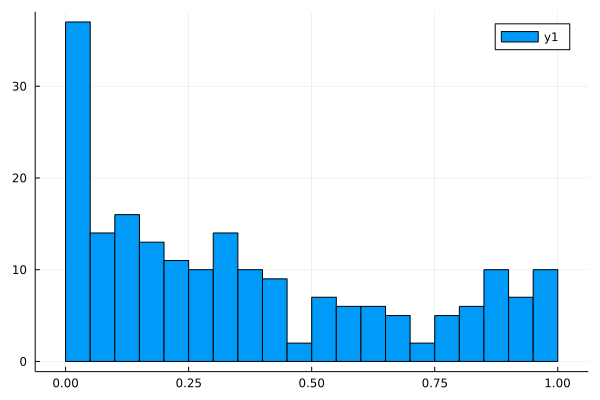

In [180]:
histogram(Pv0,bins=0:0.05:1.0) # ŷ by H0 data using optimal lower bound, h(ξ)

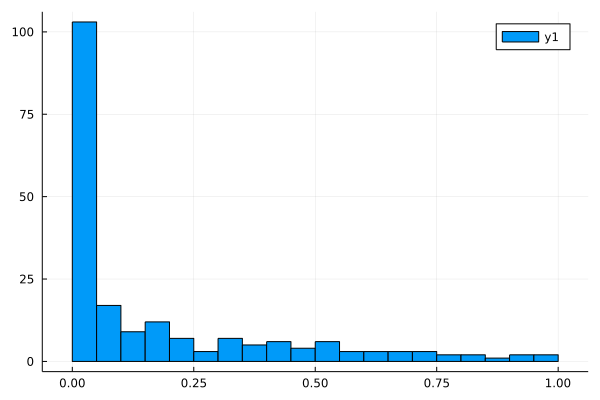

In [181]:
histogram(P1,bins=0:0.05:1.0) # ŷ by H1 data

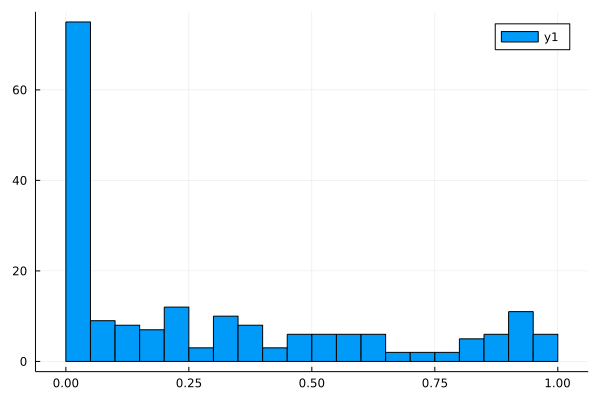

In [182]:
histogram(pval,bins=0:0.05:1.0) #using full lower bound of h(x)

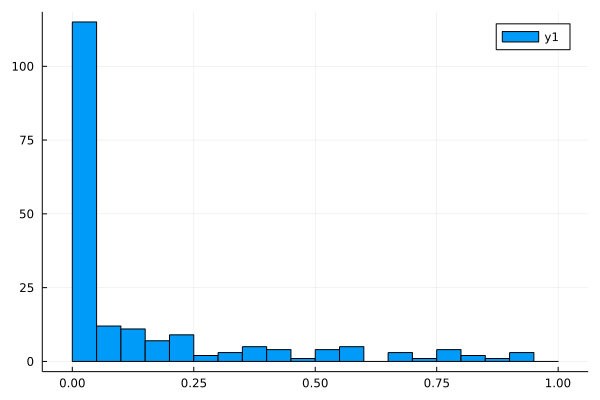

In [183]:
histogram(pval1,bins=0:0.05:1.0)

In [160]:
maximum(pval1)

1.0